In [40]:
import matplotlib.ticker as mticker
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skewnorm
import string
import matplotlib.colors as mcolors

import numpy as np
#from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import math
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
#import multiprocess
import sys
import os
import ast
import glob
from numpy import linalg
import json
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from matplotlib.colors import ListedColormap
#from math import comb


from scipy.stats import binom

#### Pre-requisute Functions

In [41]:
def create_XFR(n, t = 2,k = 2):
    if n ==2:
        t = 1

    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        if i <= t:
            F = F + vals
    
    R = {}
    react_count = 0
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                if cand2 != cand1:
                    #print(list(R.values()))
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    
                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
                    
                    if [[X[i], X[j]], [cand2]] not in list(R.values()):
                        R[react_count] = [[X[j], X[i]], [cand2]]
                        react_count +=1
                    
                    if [[cand2],[X[i], X[j]]] not in list(R.values()):
                        R[react_count] = [[cand2],[X[j], X[i]]]
                        react_count +=1
                else:
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    

                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
    
    return(X,F, R)

# Repeatedly applies reduction rule R1 until no more reductions can be made
def ReduceToRa(R,C):
    change = True
    while change:
        change = False
        supp = supportR(R)
        for r in R:
            # see if r is catalyzed by anything in support R
            if r in C:
                if set(C[r]).intersection(supp):
                    pass
                else:
                    #print(r)
                    #print(R)
                    del R[r]
                    change = True
                    break
            else:
                #print(r)
                #print(R)
                del R[r]
                change = True
                break



    return

def supportR(R):
    supp = []
    for r in R:
        supp += R[r][0] + R[r][1]

    return set(supp)

def create_catalysts (X, react_count, p):
    C = {}
    #print(X)
    #print(react_count)
    for i in X:
        #print(X)
        for j in range(1, react_count,2):
            #print(j)
            if np.random.random(1)[0] < p:
                # if j%2 == 1:
                #     k = 1
                # else:
                #     k = -1
                k = -1

                if j in C.keys():
                    if i not in C[j]:
                        C[j].append(i)
                else:
                    C[j]= [i]

                if j+k in C.keys():
                    if i not in C[j+k]:
                        C[j+k].append(i)
                else:
                    C[j+k]= [i]
    return C    

def computeClosure(F,R):
    W =set(F)
    change = True
    while change:
        change = False 
        for r in R:
            if (set(R[r][0]).issubset(W)) and (not set(R[r][1]).issubset(W)):
                W.update(R[r][1])
                change = True
    return list(W)

def ReduceToF(R, W):

    for r in list(R.keys()):
        if not set(R[r][0]).issubset(set(W)):
            del R[r]
    return 

def RAF(F,R,C):
    
    R_old = list(R.keys())
    #print("Original: {}".format(R_old))
    change = True
    while change:
        #print("R: {}".format(list(R.keys())))
        #print("ReduceToRA")
        ReduceToRa(R,C)
        #print("ComputeClosure")
        W = computeClosure(F,R)
        #print("ReduceToF")
        ReduceToF(R,W)

        #print("New R: {}".format(list(R.keys())))
        #how do i know when to stop
        if not R:
            #print("EMPTY")
            return 0
        elif R_old == list(R.keys()):
            #print("NO CHANGE")
            change = False
            return 1
        else:
            #print("KEEP GOING")
            R_old = list(R.keys())
            


    #print("Final")
    #print(R)
    if R:
        return 1
    else:
        return 0
   


In [42]:
def wiki_approx(n,k):
    if k == 0:
        return 0
    
    return k * (np.log(n)  - np.log(k))

In [43]:
def rest_part(Q, n,C):
    # THIS IS LOWKEY GARBO
    k = sum(Q)-1
    #k_fac = k * np.log(k) - k 
    #A = sum([Q[i]* np.log(i+1) for i in range(len(Q))])
    #print(k_fac)
    #print(A)
    #C = (k_fac + A)/4
    #print(C)
    
    return k * np.log(n) - C


In [44]:
[i for i in range(9,10)]

[9]

In [60]:
def raf_term(k,mR, Q, C = np.exp(19.32)):
    #bks = 0
    bks = []

    for m in range(1, k):

        
        
        part1 = rest_part(Q,m, C)
        #print(part1)
        

        #print(part1)
        singles = wiki_approx(mR - Q[0] - m, k- m)
        #print(singles)
        
        correction = rest_part(Q,k-m, C)
        #correction = 0
        #print(correction)

        if correction < singles:
            #print("m = {}".format(m))

            if (correction - singles) > -3:
                print("Not Simple")
                bks.append (np.log((np.exp(part1) * (np.exp(singles) - np.exp(correction)))))
                #bks += (np.log((np.exp(part1) * (np.exp(singles) - np.exp(correction)))))
                #bks += (np.exp(part1) * (np.exp(singles) - np.exp(correction)))
            else:
                bks.append (part1 + singles)
                #bks += part1 + singles
                #bks += np.exp(part1 + singles)
        
            #print("bk = {}".format(bks))
     
            #print("--")
    if bks:

        return bks
    else:
        return 
    #return np.log(bks)


    



def raf_bound(Q, mR, p,C = np.exp(19.32)):
    predict = {}
    sdev = mR*p*(1-p)
    for k in range(int(mR*p - 0.25*sdev), int(mR*p + 0.25*sdev)+1):
        if k == 0:
            predict[k] = 0
        else:
            #print(k)
            #comb_high_estimate = k *(np.log(mR)  + 1 - np.log(k))
            comb_high_estimate = wiki_approx(mR, k)
            #print("comb: {}".format(comb_high_estimate))
            #ways = non
            prob_term =  max(min(np.exp(log_sum(raf_term(k,mR,Q, C))- comb_high_estimate),1),0)
            #print("non-raf: {}".format(nonraf(k,mR,Q)))
            #print(prob_term)
            predict[k] = prob_term * binom(mR,p).pmf(k)
        #predict[k] = non_raf_term * binom(mR,p).pmf(k)

    return predict

In [54]:
def log_sum (vals):
    if vals:
        x = max(vals)
        adj_vals = [i- x for i in vals]
        log_s = x + np.log(np.sum(np.exp(adj_vals)))
        return log_s
    else:
        return 0

### Q Estimate

In [47]:
weighted_avg = 260
sigma = weighted_avg/4
skew_A = 50000000
a = 5

ls = [1]
Q_estimate = [96]


for i in range(2,int(weighted_avg+3*sigma)):
    
  
    if skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma) >= 1:
        ls.append(i)
        
        Q_estimate.append(int(skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma)))
    # elif i > mu:
    #     break
    else:
        ls.append(i)
        Q_estimate.append(0)

In [48]:
X,F,R = create_XFR(6)
mR = int(len(X) * len(R)/2)

exponent = 19.35

### Conditional Prob + Binom

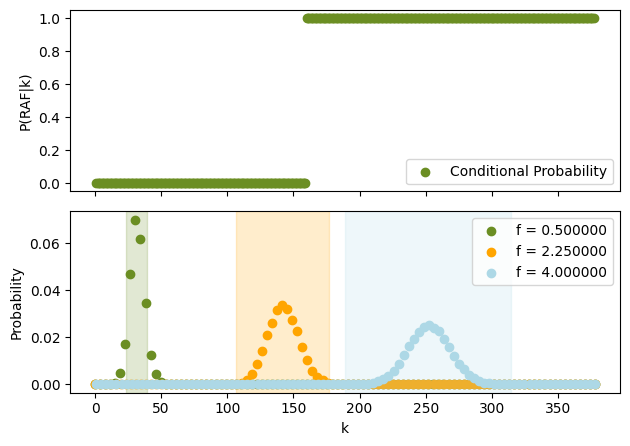

In [81]:
max_it = int(mR * 6/len(R))

# Create a 2x1 grid of subplots
#figsize=(8, 6)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the conditional probability on the first subplot
k_values = [i for i in range(1, max_it)]
conditional_probability = [np.exp(min(log_sum(raf_term(i, mR, Q_estimate, C=np.exp(19.35))) - wiki_approx(mR, i), 0)) for i in k_values]
ax1.scatter(k_values, conditional_probability, label='Conditional Probability', color='#6B8E23')
#ax1.set_title('Conditional Probability and Distributions of k')
ax1.set_ylabel('P(RAF|k)')
ax1.tick_params(axis='y')
ax1.legend(loc='lower right')

# Plot the binomial distributions on the second subplot
colors = ['#6B8E23', '#FFA500', '#ADD8E6']  # Predefined color list
for i, p in enumerate(np.linspace(0.5, 4, 3) / len(R)):
    sdev = mR * p * (1 - p)
    x_vals = np.linspace(mR * p - sdev, max_it, 100)  # Adjust linspace range
    binom_y = [binom.pmf(int(i), mR, p) for i in x_vals]
    color = colors[i % len(colors)]  # Cycle through the color list
    ax2.scatter(x_vals, binom_y, label="f = {:.6f}".format(p * len(R)), color=color)
    ax2.axvspan(mR * p - 0.25 * sdev, mR * p + 0.25 * sdev, alpha=0.2, color=color)

ax2.set_xlabel('k')
ax2.set_ylabel('Probability', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

# Add a total figure title
#fig.suptitle('Conditional Probability and Binomial Distributions', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


### Theoretical Model vs Simulation

In [56]:
df = pd.read_csv("Data/sim_plot_data.csv")

sim_data = df.groupby('n').mean().loc[6]

/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_1128/2495416720.py:61: RuntimeWarning: overflow encountered in exp
  prob_term =  max(min(np.exp(log_sum(raf_term(k,mR,Q, C))- comb_high_estimate),1),0)


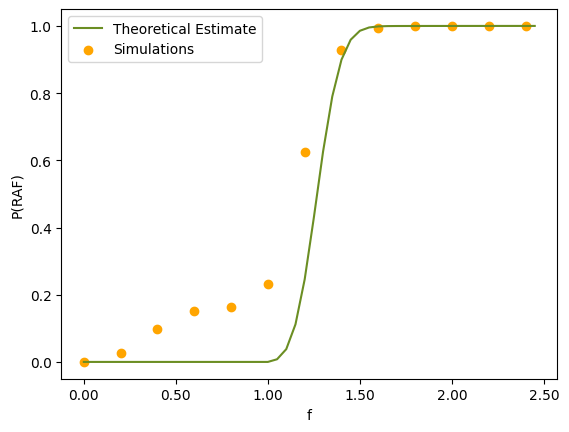

In [75]:
#figsize= (9,6)
fig, ax = plt.subplots()
fs = np.arange(0,2.5,0.05)



colors = ['#6B8E23', '#FFA500', '#ADD8E6']  # Predefined color list

ax.plot(fs, [sum(raf_bound(Q_estimate, mR, 2*p/len(R), C = np.exp(exponent)).values()) for p in fs],color = colors[0], label='Theoretical Estimate')

ax.scatter(sim_data.index.astype(float),sim_data.values, color = colors[1], label='Simulations')
#half_ind =[ (i - 0.5)**2 for i in  lower_bound].index(min([ (i - 0.5)**2 for i in  lower_bound]))

#[sum(raf_bound(Q_estimate, mR,p, C = np.exp(exponent)).values()) for p in np.linspace(0.5, 4, 50) / len(R)]
# Create an inset plot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# ax_inset = inset_axes(ax, width="35%", height="35%", loc='upper left',
#                       bbox_to_anchor=(0.05, - 0.075, 1, 1), bbox_transform=ax.transAxes ) # Positioning the inset
# ax_inset.scatter(ls, Q_estimate, color='midnightblue', label='Q Estimate {}, {}, {}'.format(weighted_avg, sigma, skew_A))

# Set titles and labels
#ax.axvline(2.25)
#ax.axvline(fs[half_ind], color = "olivedrab")
#ax.set_title('P(RAF) Theoretical Estimate as Function of Q Estimates')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.set_xlabel('f')
ax.set_ylabel('P(RAF)')

ax.legend()
#ax_inset.legend(loc='lower left')


plt.show()

### Exponential vs Log Terms in Conditional Probability

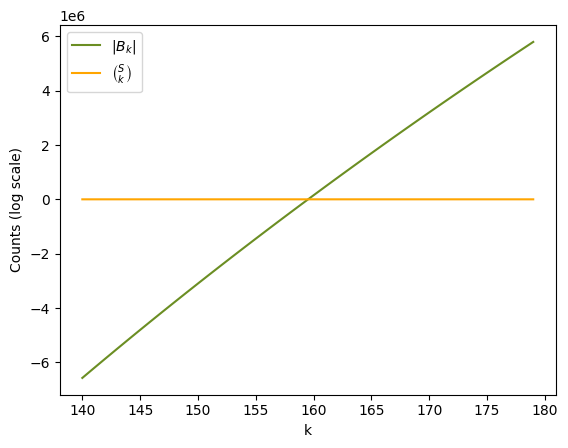

In [63]:
init_val = 140
max_val = 180

colors = ['#6B8E23', '#FFA500', '#ADD8E6']
plt.plot([i for i in range(init_val,max_val)], [log_sum(raf_term(i, mR, Q_estimate, C =np.exp(exponent))) for i in range(init_val,max_val)], label='|$B_k$|', color=colors[0])
plt.plot([i for i in range(init_val,max_val)], [wiki_approx(mR, i) for i in range(init_val,max_val)], label=r'$\binom{S}{k}$', color=colors[1])
#plt.title('Terms in Conditional Probability')""
plt.xlabel('k')
plt.ylabel('Counts (log scale)')
plt.legend()

0.0

### Hordjik04 Plot


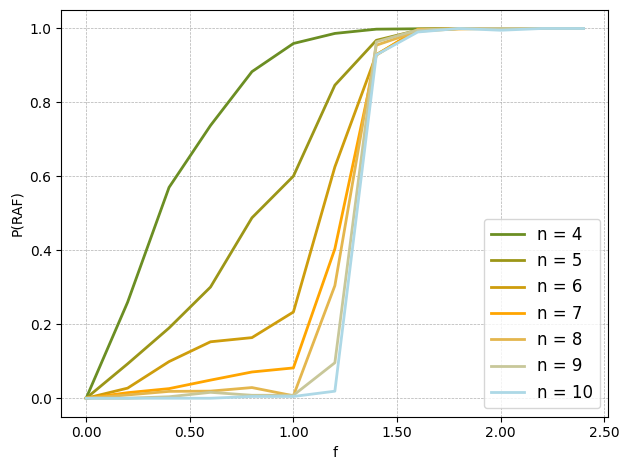

In [76]:
file_path = 'Data/sim_plot_data.csv'
all_runs_data = pd.read_csv(file_path)
f_vals = all_runs_data.columns 
average_data = all_runs_data.groupby('n').mean()
#print(average_data)
#print(average_data.columns.astype(float))
#print(f_vals)

# Function to create a gradient between multiple colors
def create_color_gradient(colors, n_points):
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', colors, N=n_points)
    return [mcolors.to_hex(cmap(i / n_points)) for i in range(n_points)]

# Create a gradient that transitions from olive green to orange to light blue
gradient_colors = create_color_gradient(['#6B8E23', '#FFA500', '#ADD8E6'], len(average_data.index))

# Plot using the new gradient color palette
#plt.figure(figsize=(8, 6))

for i, row in enumerate(average_data.index):
    #print(average_data.loc[row])
    plt.plot(average_data.columns.astype(float), average_data.loc[row], label=f'n = {row}', color=gradient_colors[i], linewidth=2)

# Improving plot aesthetics for publication quality
#plt.title('F vs Data with Gradient from Olive Green to Light Blue', fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.xlabel('f')
plt.ylabel('P(RAF)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Save as a high-quality image
plt.savefig('../Paper/Figures/avg_PhaseTransition.png', dpi=300)

### Varying Trasnition Point

In [65]:
weighted_avg = 225
sigma = weighted_avg/4
skew_A = 50000000
a = 5


Q_estimate_075 = [96]
exponent_075 = 19.25


for i in range(2,int(weighted_avg+3*sigma)):
    
  
    if skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma) >= 1:
        #ls.append(i)
        
        Q_estimate_075.append(int(skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma)))
    # elif i > mu:
    #     break
    else:
        #ls.append(i)
        Q_estimate_075.append(0)



In [66]:
weighted_avg = 250
sigma = weighted_avg/4
skew_A = 50000000
a = 5

Q_estimate_125 = [96]
exponent_125 = 19.35


for i in range(2,int(weighted_avg+3*sigma)):
    
  
    if skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma) >= 1:
        #ls.append(i)
        
        Q_estimate_125.append(int(skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma)))
    # elif i > mu:
    #     break
    else:
        #ls.append(i)
        Q_estimate_125.append(0)

In [67]:
weighted_avg = 300
sigma = weighted_avg/4
skew_A = 50000000
a = 5
Q_estimate_175 = [96]
exponent_175= 19.42


for i in range(2,int(weighted_avg+3*sigma)):
    
  
    if skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma) >= 1:
        #ls.append(i)
        
        Q_estimate_175.append(int(skew_A*skewnorm.pdf(x =i, a =-a, loc = weighted_avg+1, scale = sigma)))
    # elif i > mu:
    #     break
    else:
        #ls.append(i)
        Q_estimate_175.append(0)

In [42]:
sum(Q_estimate_175)- 1

49996650

In [68]:
fs = np.arange(0,2.75,0.01)
bound_075 = [sum(raf_bound(Q_estimate_075, mR, 2*p/len(R), C = np.exp(exponent_075)).values()) for p in fs]
bound_125 = [sum(raf_bound(Q_estimate_125, mR, 2*p/len(R), C = np.exp(exponent_125)).values()) for p in fs]
bound_175 = [sum(raf_bound(Q_estimate_175, mR, 2*p/len(R), C = np.exp(exponent_175)).values()) for p in fs]

/var/folders/rz/8ns_4y5958ldxyg1ckf2wd0c0000gn/T/ipykernel_1128/2495416720.py:61: RuntimeWarning: overflow encountered in exp
  prob_term =  max(min(np.exp(log_sum(raf_term(k,mR,Q, C))- comb_high_estimate),1),0)


In [41]:
sum(Q_estimate_075)- 1

49996668

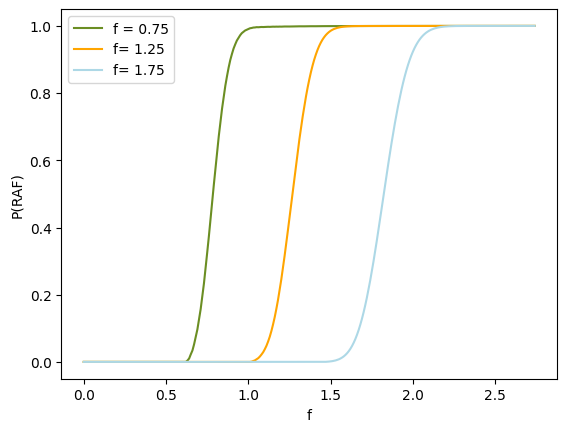

In [78]:
fig, ax = plt.subplots()
fs = np.arange(0,2.75,0.01)




#colors = ['#6B8E23', '#FFA500', '#ADD8E6']  # Predefined color list

#ax.plot(fs, [sum(raf_bound(Q_estimate, mR, 2*p/len(R), C = np.exp(exponent)).values()) for p in fs],color = colors[0], label='Theoretical Estimate')


ax.plot(fs, bound_075,color = '#6B8E23', label='f = 0.75')
ax.plot(fs, bound_125,color = '#FFA500', label='f= 1.25')
ax.plot(fs, bound_175,color = '#ADD8E6', label='f= 1.75')



#ax.scatter(np.linspace(0,4,10), sim_data,color = "darkolivegreen", label='Simulations')
#half_ind =[ (i - 0.5)**2 for i in  lower_bound].index(min([ (i - 0.5)**2 for i in  lower_bound]))

# max_len = 325
# # Create an inset plot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# ax_inset = inset_axes(ax, width="25%", height="25%", loc='lower right',
#                       bbox_to_anchor=(-0.025,  0.05, 1, 1), bbox_transform=ax.transAxes ) # Positioning the inset
# ax_inset.plot([i for i in range(len(Q_075))], Q_075, color='orangered', label='Core Distribution')
# ax_inset.plot([i for i in range(len(Q_22))], Q_22, color='darkgreen', label='Core Distribution')
# ax_inset.plot([i for i in range(max_len)], Q_32[:max_len], color='cornflowerblue', label='Core Distribution')


# Set titles and labels
#ax.axvline(2.25)
#ax.axvline(fs[half_ind], color = "olivedrab")
#ax.set_title('Varying P(RAF) Transition Point as a function of Core Distribution')
ax.set_xlabel('f')
ax.set_ylabel('P(RAF)')

ax.legend()
plt.show()
#ax_inset.set_title('Core Distributions')

### Misc

In [67]:
n = 30
1.0970 + 0.0189*n

1.664